In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [2]:
path = tf.keras.utils.get_file('sunspots.csv', 
                               '  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv')
print (path)

C:\Users\Amir\.keras\datasets\sunspots.csv


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
df = pd.read_csv(path, index_col='Date', parse_dates=True)
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df.columns = ['Sunspots']   # reaname column
#df.plot(figsize=(10,6))

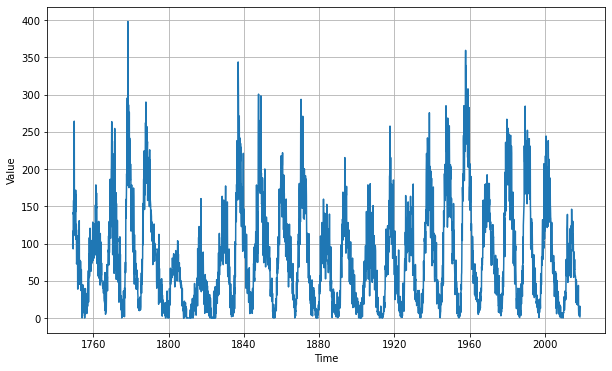

In [5]:
series = np.array(df['Sunspots'])
time = np.array(df.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [7]:
n_input = 60
n_features = 1
n_batch_size = 32

In [8]:
x_train = x_train.reshape((len(x_train), n_features))

In [9]:
generator = TimeseriesGenerator(x_train, x_train,
                                length = n_input, 
                                sampling_rate = 1, 
                                batch_size = n_batch_size, 
                                shuffle = True)

In [10]:
# check the dimentions
x, y = generator[1]
print(x.shape)
print(y.shape)

(32, 60, 1)
(32, 1)


In [11]:
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape = (n_input,n_features)))
model.add(LSTM(60))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 60)            14880     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dense (Dense)                (None, 30)                1830      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 46,071
Trainable params: 46,071
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))

In [14]:
model.fit(generator,epochs=100,verbose=0)

In [15]:
# We need to make it 2 dimimention - because RNN needs 3D
series_2d = np.array(df['Sunspots'])
print(series_2d.shape)
series_2d = series_2d.reshape((len(series_2d), n_features))
print(series_2d.shape)

(3235,)
(3235, 1)


In [16]:
forecast=[]
for time in range(len(series_2d) - n_input):
  forecast.append(model.predict(series_2d[time : time + n_input][np.newaxis]))

In [17]:
forecast = forecast[split_time-n_input:]

In [18]:
results = np.array(forecast)[:, 0, 0]
results.shape

(235,)

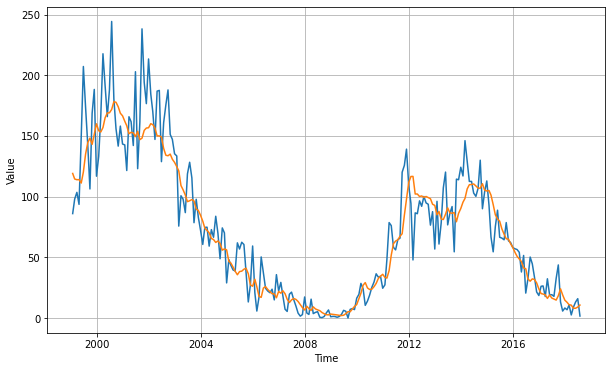

In [19]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [20]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

14.858697

In [35]:
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

test_errors = {}

test_errors ['MAX_Error'] = max_error(x_valid, results)
test_errors ['MAE'] = mean_absolute_error(x_valid, results)
test_errors ['RMSE'] = mean_squared_error(x_valid, results, squared=False)
test_errors ['MSE'] = mean_squared_error(x_valid, results, squared=True)

pd.Series(test_errors)

MAX_Error     90.057315
MAE           14.858697
RMSE          21.590144
MSE          466.134329
dtype: float64